In [2]:
import os
from pathlib import Path

def root_dir(marker="EXPLib"):
    cwd = Path.cwd()
    # if cwd already contains the marker
    if (cwd / marker).is_dir():
        return cwd
    # otherwise walk up the parents
    for p in cwd.parents:
        if (p / marker).is_dir():
            return p
    raise FileNotFoundError(f"Root marker '{marker}' not found")

os.chdir(root_dir())
#print(os.getcwd())

In [ ]:
import torch
import os
import cv2
import numpy as np
from PIL import Image
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image
from EXPLib.xai_library.model_explainers.model_utils.toymodel_utils import load_and_configure_model, preprocess_image, perform_inference_and_visualize
from EXPLib.xai_library.model_explainers.cam.toymodel_cam.toymodel_cam_utils import ToyModelScoreTarget, draw_boxes, predict, toymodel_reshape_transform

In [3]:
image_path = 'EXPLib/datasets/Camera/toy_model_v1_inference/dev/images'
image_file = 'rgb_0000100.png'
weight_path = 'EXPLib/dl_component/CNN/Object_Detectors/toy_model_v1'
weight_file = 'aikonet_toymodelv1_ssdlite.pth'

model_name = 'ssdlite320_mobilenet_v3_large'
num_classes = 2

############################################################################
# Check if a GPU is available and if not, use a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# load model
model = load_and_configure_model(model_name, weight_path, weight_file, num_classes, device)
model.eval()
# load image
image = preprocess_image(image_path, image_file, device)
processed_torch_inputs=image

e:\RISE-OneDrive\RISE\SAFEXPLAIN-WP3 XAI - General\EXPLib20\EXPLib\xai_library\model_explainers\model_utils\toymodel_utils.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

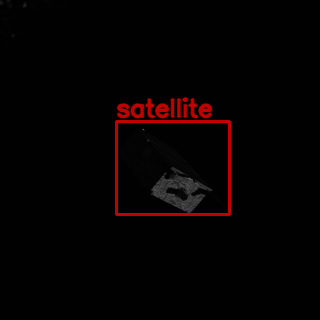

In [5]:
orig_image = cv2.imread(os.path.join(image_path, image_file))
boxes, classes, labels, indices = predict(processed_torch_inputs, model, device, 0.9)
bbox_image = draw_boxes(boxes, labels, classes, orig_image)
Image.fromarray(bbox_image)

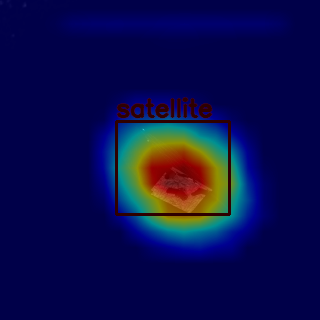

In [6]:
target_layers = [model.backbone]
labels=[1]
targets = [ToyModelScoreTarget(labels=labels, bounding_boxes=boxes)]
cam = EigenCAM(model,
              target_layers,
              reshape_transform=toymodel_reshape_transform)
grayscale_cam = cam(image, targets=targets)
# Take the first image in the batch:
grayscale_cam = grayscale_cam[0, :]
image_float_np = np.float32(orig_image) / 255
cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)
Image.fromarray(image_with_bounding_boxes)